# Taking off the Training Weels: Re-Balancing the Citibike System

**Author: Mitchell Krieger**

## Overview

***

Citibike and other similar bike sharing systems face a unique challenge in balancing their system. Bikes must be distrubted across all stations so that riders have access to both bikes to take out and empty docks to return bikes to. Unchecked, this challenge may cause bikes to pool in certain station and drain from others. This project attemps to understand which stations in the Citibike system are pools, drains or balanced. To do this, time series analysis was used to predict the number of bikes at a given station given the time and then based on their extracted daily seasonality from the time series model, classify stations as pools, drains or balanced.

## Bussiness Understanding

***

Bike-sharing systems have a specific challenge when it comes to a user’s experience: bike stations can’t be empty because then riders will have no bike to take out. However, bike stations also shouldn’t be full because then riders will have no place to dock a bike. This dichotomy takes on additional complexity when you factor in things like the direction of rider traffic flow, time of day, weather, and hills. These elements among other user habits often will cause a Bike-share system to become “unbalanced”. The two indicators of an unbalanced system are:

- Bike Drains: Riders will take bikes out of certain areas but not return them on their commute back causing a scarcity of bikes and empty stations (Possible example causes: stations on top of hills/in a hilly area, Residential areas during the morning commute, etc)
- Bike Pools: Riders will deposit bikes but not take them out causing an abundance of bikes and no docks (Possible example causes: stations far from other modes of transit, sun setting before end of the workday)

When a system is unbalanced, the drains and pools make finding/returning a bike impossible and disrupt the user experience. Therefore the balancing of the system is a critical task for CitiBike and other bike-share systems to manage on an hourly basis. CitiBike currently uses four methods to re-balance the system:

- Bike Trains: A CitiBike employee who move bikes on specialty bike attachment, good for short distance re-balancing and eco-friendly
- Vans: Used to collect/redistribute bikes, good for long-distance rebalancing and collecting broken bikes, good for mass collection/redistribution, but poor for the environment
- Valets: CitiBike employees who service stations where bikes are in high demand with new bikes, good for customer service
- Bike Angels: A program where riders are rewarded points for riding bikes from pools to drains, good for brand loyalty and offloading work to riders

While having these methods are great, Citibike will still have to forecast where and when bikes are going to be needed and when in order to effectively deploy them. AI and Machine Learning can be used to predict where the demand for bikes will be and thus help identify where re-balancing methods need to focus their efforts. This project uses multivariate time-series anlysis to forcast bike demand and then un-supervised classification (clustering) to identify bikes as pools, drains or balanced.



## Data

***

Live feed station data and trip history is available through [CitiBike’s open system data](https://www.citibikenyc.com/system-data). In addition, historical timestamped station data through April 2019 was collected from [The Open Bus project](https://www.theopenbus.com/methodology.html). For the sake of modeling, processing power, data availability and simplicity, this project will focus its analysis using data from 2018-present only, mostly focusing on 2018. 


### Data preparation and cleaning

The `cleaning.py` and `station.py` scripts found in this repository, cleans data and create a a `Station` class for easy access to elements of the various datasets and creates cleaned data pickle files 

#### Import relevant packages

In [50]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('seaborn')
import seaborn as sns
import pickle

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from cleaning import *
from station import *

#### Clean data and generate pickle files for later use
The `pickle_data()` function reads raw csv files found in `station_data` and `trip_data` folders into dataframes, cleans them and saves stores in a pickle files in `pickle` for later use in notebooks and scripts

In [2]:
pickle_data()

### The Station Class

The station class has access to pickled dataframes and can pull out key information and features important to the Citibike System Analysis. The `info.()` method pull out high overview of a station

In [51]:
station_example = Station(72) #the station class required a valid 2018 station id 
station_example.info() #the info method displays station and bike information


        #### Station 72 Info ####
        
        Name: W 52 St & 11 Ave
        Status: active
        Legacy ID: 72
        Type: classic
        Region: NYC District 
        Coordinates: (40.76727216,-73.99392888)
        Rental Methods: ['CREDITCARD', 'KEY']
        Has Kiosk: True
        
        #### Bike Stats ####
        
        As of: 2020-12-16 17:37:12
        Capacity: 55
        Available Bikes: 15
        Available Docks: 40
        Disabled Bikes: 0
        Disabled Docks: 0
        


**Station Class Plotting**

The class can plot various time series related to the specific station at a given interval in 2018 and a resampling size.

For example if we reample station hourly for the entire year, it yeilds the following graphs:

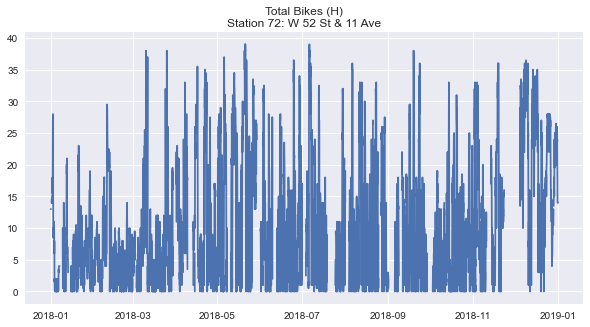

In [52]:
#plot availble bikes
station_example.plot_avail_bikes(resample='H',time_interval=('2018-01-01','2018-12-31'))

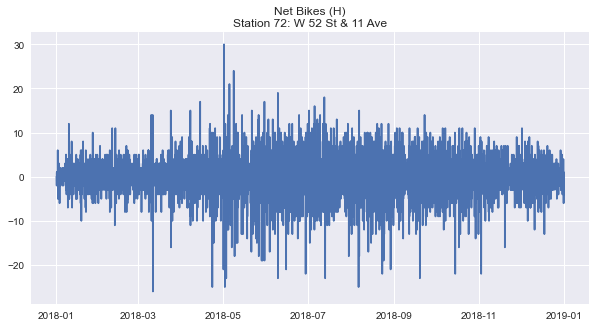

In [53]:
#plot net bikes in/out of station
station_example.plot_net_bikes(resample='H',time_interval=('2018-01-01','2018-12-31'))

In the net bike graph above you can see the major rebalancing effors when the station gains/looses +/- 20 bikes in a given hour, while in both you can see that dispite the chaning seasons and cold weather the number of bikes at this station still flutuates even with potentially less ridership.

**Station Seasonality**

The class can also check for seasonality and stationarity of a time series related to net bikes in/out of a station or available bikes at a station:

Dickey-Fuller test: 

Test Statistic                  -5.358237
p-value                          0.000004
#Lags Used                       6.000000
Number of Observations Used    329.000000
Critical Value (1%)             -3.450384
Critical Value (5%)             -2.870365
Critical Value (10%)            -2.571472
dtype: float64

Stationary: p-value 4.1429388522890785e-06 < 0.05


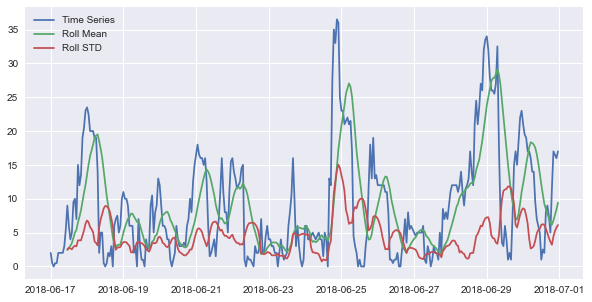

In [54]:
#check for stationarity from June 17, 2018 to June 30, 2018
station_example.availbike_stationarity(resample='H',time_interval=('2018-06-17','2018-06-30'),window=12);

This time series passed the Dickey-Fuller test implying its stationarity, although the graphs of the rolling means/standard deviations seem to fluctuate a somewhat. We'll take this as stationary.

**Station Seasonality**

This particular interval of Station \#72 seems to have both weekly (based on the trend line) and daily seasonality. Models will need to be sophisticated enough to capture both seasonalities to perform well.

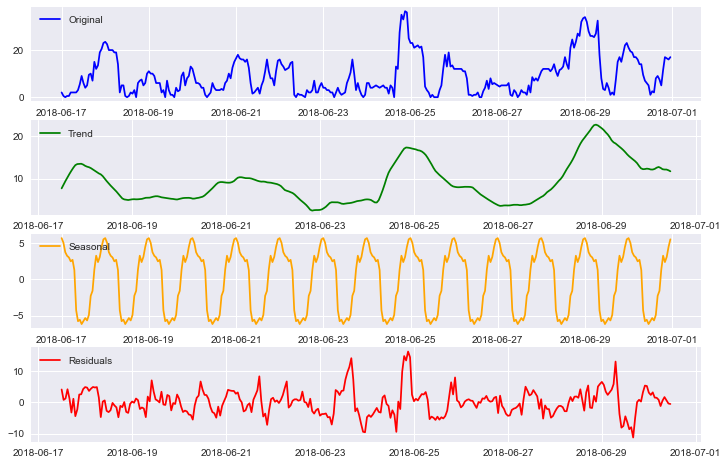

In [55]:
#check for seasonality through decomposition
station_example.availbike_decompose(resample='H',time_interval=('2018-06-17','2018-06-30'))

### Missing Data 

Due to the reliability of station feeds from both citibike and open bus there is a significant amount of missing station data as shown in the heatmat below. We'll hold off on handling missing data because different time series modeling techniques may require different approches to missing data (ex. Facebook Prohet can handle missing data where as SARIMA cannot)

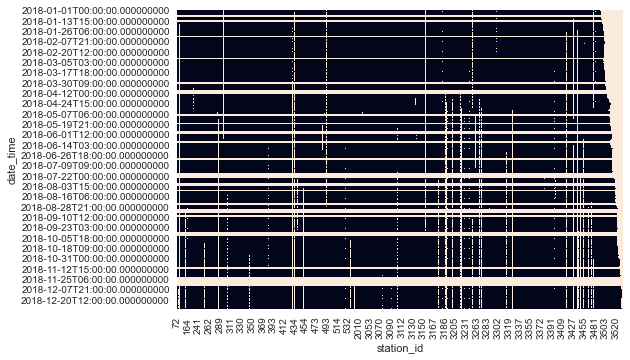

In [9]:
year_2018 = pickle.load(open('./pickle/historical.pickle','rb'))
station_mat = year_2018.avail_bikes.swaplevel().unstack().resample('H').mean()
sns.heatmap(station_mat.isnull(),cbar=False)

The horizontal bars imply missing data due to collection error from open bus. Vertical bars imply missing data due to an error on citibike's end such as  station malfunction, new stations being onboarded throughout 2018, or temporary closure of the enture system due to snowstorm. 

Individual trip data on the otherhand, rows of missing data were dropped because they weren't in the Jersey City/NYC regions. All other rows were complete:

In [10]:
#read in trips
trips_2018 = pickle.load(open('./pickle/trips.pickle','rb'))

#check for null
trips_2018.isna().sum()

tripduration               0
starttime                  0
stoptime                   0
start_station_id           0
start_station_name         0
start_station_latitude     0
start_station_longitude    0
end_station_id             0
end_station_name           0
end_station_latitude       0
end_station_longitude      0
bikeid                     0
usertype                   0
birth_year                 0
gender                     0
day_of_week                0
weekday                    0
dtype: int64

## Exploratory Data Analysis
***

### Number of Stations
NYC stations have grown significantly in number since 2018, this is mostly due to the [planned phase 3 expansion](https://www.citibikenyc.com/blog/major-citi-bike-expansion-map-revealed) fo citibike into upper manhattan neighborhoods, the brox, Queens, and Brooklyn that occured in 2019/2020 and will continue through 2023. This may cause problems in modeling and predicting because stations that existed in 2018 may have been discontinued, and new stations have been established with new riding patterns the models will not have seen. It is also important to separate out Jersey City from NYC when working on rebalancing. While JC riders can use NYC bikes and vice versa, citibikes are not allowed to be taken from one region to another. Biking between bouroughs however is allowed.

In [11]:
#read in live stations for 2020
live_stations = pickle.load(open('./pickle/live.pickle','rb'))

#Region 70 is Jersey City and Region 71 is NYC
live_stations.region_id.value_counts()

71    1159
70      51
Name: region_id, dtype: int64

Text(0.5, 1.0, 'Number of Stations')

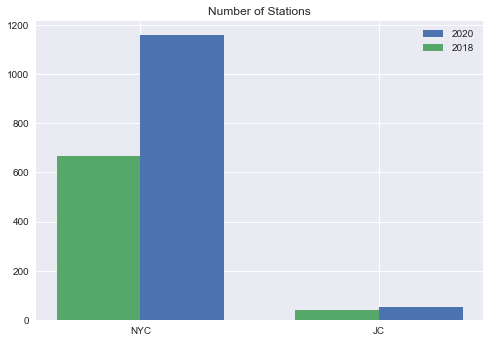

In [12]:
#separate JC and  stations for 2018
jc_stations = live_stations.loc[live_stations.region_id=='70'].station_id.values #JC stations in 2020
stations_in_2018 = list(year_2018.index.get_level_values(level=-2).unique()) #gets all stations
jc_stations_2018 = [x for x in stations_in_2018 if x in jc_stations] 
station_counts_2018 = [len(stations_in_2018)-len(jc_stations_2018),len(jc_stations_2018)]

#plot JC & NYC in 2018 vs 2020
fig,ax = plt.subplots()

x= np.array([0,1])

bar_2020 = ax.bar(x + .35/2,live_stations.region_id.value_counts(),.35,label='2020')
bar_2018 = ax.bar(x - .35/2, station_counts_2018,.35,label='2018')
ax = plt.gca()
#ax.set_ylim(top=1300)
ax.set_xticks([0,1])
ax.set_xticklabels(['NYC','JC'])
ax.legend()
plt.title('Number of Stations')

### Rides Per Month

Rides peak in the summer months, however, May through October the monthly count is all close to one another. 

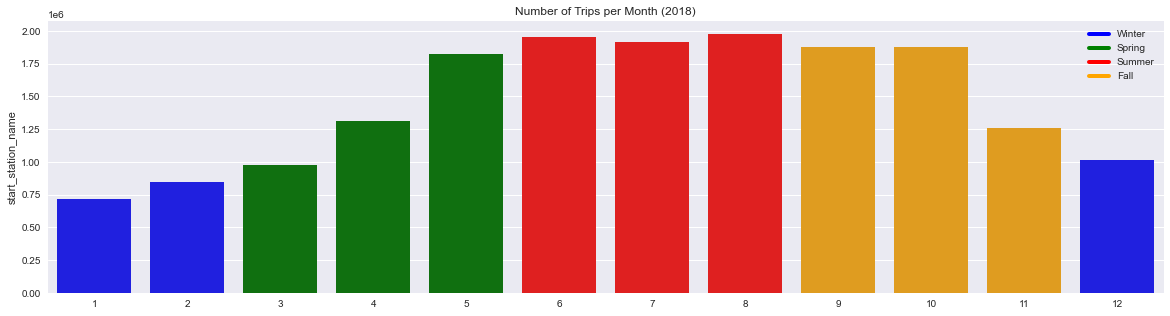

In [43]:
#Read in trips by start time
starts = pickle.load(open('./pickle/starts.pickle','rb'))

#count trips by month
trips_per_month = starts.droplevel(level=-2).start_station_name.resample('M').count()

#create season colors for legend
legend_colors = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='orange', lw=4)]

#plot
fig = plt.figure(figsize=(20,5))
sns.barplot(x=list(trips_per_month.index.month),y=trips_per_month,palette=['b','b','g','g','g','r','r','r','orange','orange','orange','b'])
plt.title('Number of Trips per Month (2018)')
plt.legend(legend_colors, ['Winter','Spring','Summer','Fall'])

### Rides Per Day
On a daily basis, we see a similar trend to the monthly above, however, its clear there are days when ridersip significantly lower even in summer months. This could be due to weather, weekends vs weekdays etc.

Text(0.5, 1.0, 'Number of Trips per Day (2018)')

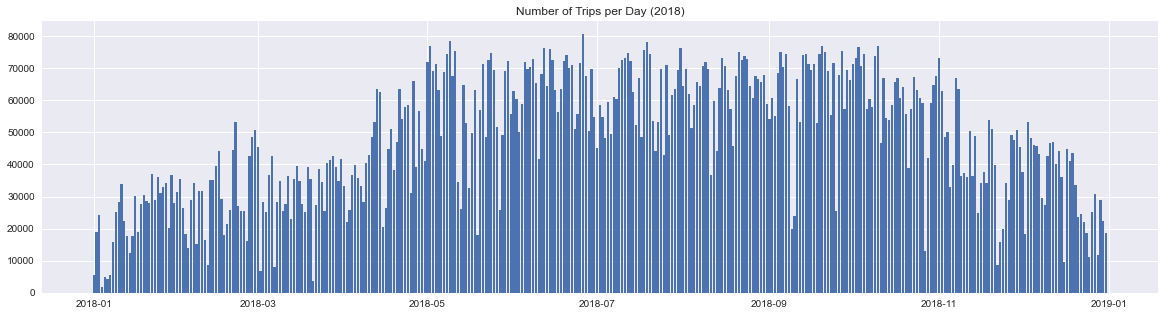

In [14]:
trips_per_day = starts.droplevel(level=-2).start_station_name.resample('D').count()

fig = plt.figure(figsize=(20,5))
plt.bar(trips_per_day.index,trips_per_day)
plt.title('Number of Trips per Day (2018)')



### Plotting Geograhpic Distribution of Bikes over time

This map shows potential drains and pools. For example: Red Hook and other neighborhoods deep in Brooklyn almost always has near full bike docks indicating bike pooling, while in east Harlem, bike docks are nearly always near empty. Brooklyn and JC overall seem to have more balanced stations. This might indicate: 
- Less clear boundaries between residential and business areas in Brooklyn & JC than Manhattan
- Few people cross NYC bridges on citibike (JC riders can use bikes in both regions but are not allowed to ride from one region to another)
- People in Brooklyn and JC have commutes too long to take a citibike for

In addition the animation shows clear pattern of how bikes move on a typical daily weekday season. On weekends however, this pattern is not present (see full html). Between individual weekdays the pattern only has minor differences.

In [15]:
import json

#get mapbox API key for plotting
path = '/Users/mitchellkrieger/.secret/mapbox_api.json'

with open(path) as f:
    api = json.load(f)
    
api_key = api['api_token']

In [16]:
# prepdata for geographic plotting
hours = year_2018.groupby([pd.Grouper(freq='H',level='date_time'),
                  pd.Grouper(level='station_id')]).mean()
hours['id']=[i[1] for i in list(hours.index)]
hours['dt']=[str(i[0]) for i in list(hours.index)]

#slice a particular 2 weeks to plot
hours_slice = hours.xs(slice('2018-06-17','2018-06-30'),level=-2)

#The following code is commented out to reduce size of notebook. Download percent_full_map.hmtl in repo to use interactive map.
#replaced with gif representation of short slice of full html rendering below

#import plotly.express as px

# px.set_mapbox_access_token(api_key)
# fig = px.scatter_mapbox(hours_slice, lat="_lat", lon="_long",
#                         animation_frame='dt', animation_group='id',
#                         color="percent_full", size="avail_bikes",
#                         color_continuous_scale=px.colors.cyclical.IceFire, size_max=15,
#                         zoom=10,width=800,height=800)

# fig.write_html('percent_full_map.html')
# fig.show()

![percent_full_map](./images/map.gif)

### Weekly Analysis

#### Weekend vs Weekday
On Weekdays, the system sees heavy traffic around rush hour commuting times in the morning (8-9am) and in the (5-7pm). While weekend peak riding hours are in the afternoon. Ridership nears zero on weekends and weekdays in the early morning hours (1am-5am), potentially a good time for rebalancing and other system maitenence. Daily seasonality is also shown her, the number of trips at the 00:00 mark is near the number of rides at 23:59.

In [17]:
#starts is a multi index dataframe of trips organized by station id and datetime of trip
starts = pickle.load(open('./pickle/starts.pickle','rb')) 

In [18]:
#separate trips into weekdays and weekends
weekdays = starts[starts.weekday==True].droplevel(level=-2)
weekends = starts[starts.weekday==False].droplevel(level=-2)

Text(0, 0.5, 'Rides per Week')

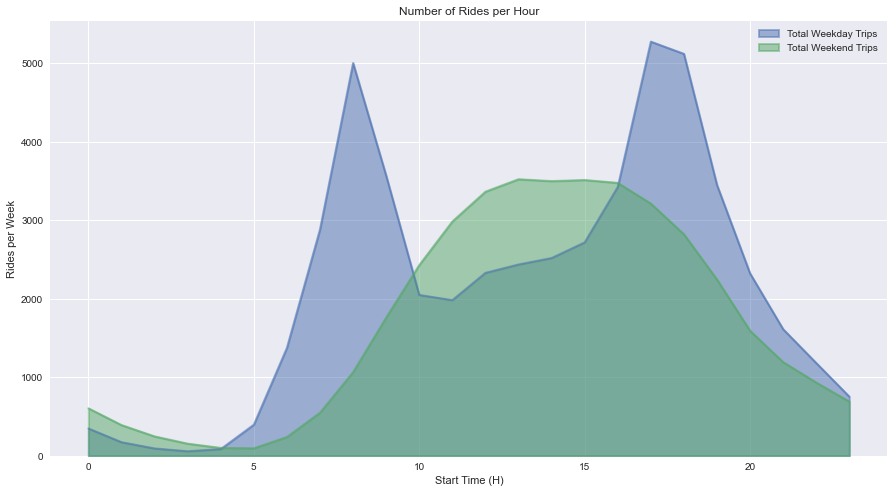

In [19]:
plt.figure(figsize=(15,8))

#plot number of rides per the 52 sets of 5 weekday days and 52 sets of 2 weekend days
(weekdays.groupby(weekdays.index.hour).size()/52/5).plot(kind='area',label='Total Weekday Trips',linewidth=2,alpha=.5)
(weekends.groupby(weekends.index.hour).size()/52/2).plot(kind = 'area',label='Total Weekend Trips',linewidth=2,alpha=.5)
plt.legend()
plt.title('Number of Rides per Hour')
plt.xlabel('Start Time (H)')
plt.ylabel('Rides per Week')

#### Day by Day
The heatmap below shows the day by day hourly breakdown of trips. Again we see peak on the weekdays during rush hours and during the afternoon on weekends. This also shows that of weekdays, Monday mornings, Friday mornings, and friday afternoons have less riders than other weekday commute times. This is perhaps due to proximity to weekend activities.

Text(0.5, 88.0, 'Day of Week')

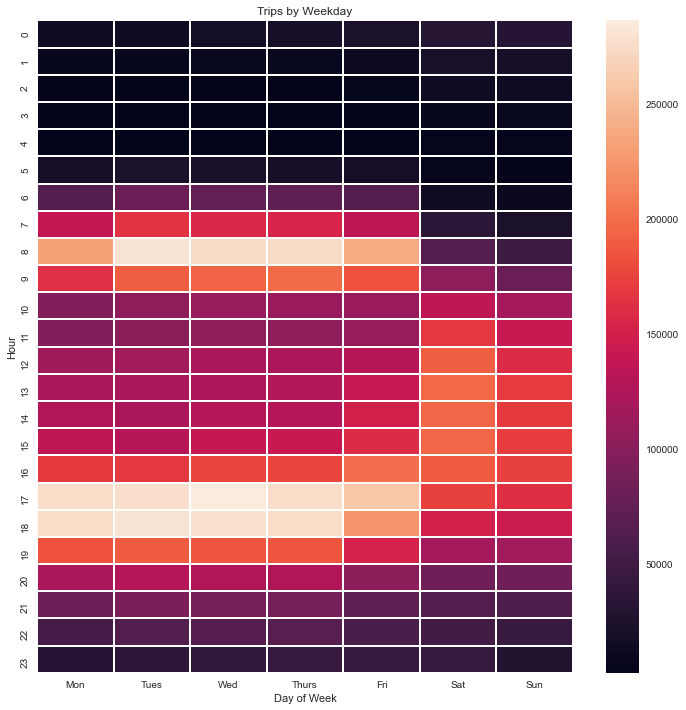

In [72]:
starts_by_weekday = starts.droplevel(level=-2)
starts_by_weekday = starts_by_weekday.groupby([starts_by_weekday.index.hour,'day_of_week']).size()

plt.figure(figsize=(12,12))
sns.heatmap(starts_by_weekday.unstack(), xticklabels = ['Mon','Tues','Wed','Thurs','Fri','Sat','Sun'],
           linewidths=1)
plt.title('Trips by Weekday')
plt.ylabel('Hour')
plt.xlabel('Day of Week')

### Ride Length

The vast majority of riders take bikes within the alloted time limit. This is important because it means that bikes will only ever be moved in one trip in a 45 minute distance of the start station, effectively contibuting to pooling if stations are isolated far away from other stations.

Text(0, 0.5, 'Number of Trips')

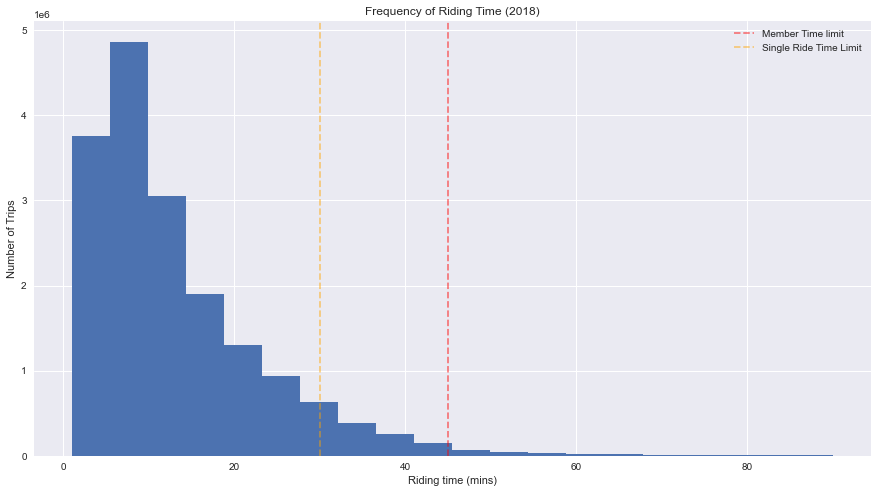

In [20]:
trips_2018.tripduration = trips_2018.tripduration/60
plt.figure(figsize=(15,8))
trips_2018.loc[trips_2018.tripduration <= 90].tripduration.plot(kind='hist',bins = 20,label='')
plt.axvline(x=45,color='red',label='Member Time limit',linestyle = '--',alpha=.5)
plt.axvline(x=30,color='orange',label='Single Ride Time Limit',linestyle='--',alpha=.5)
plt.legend()
plt.title('Frequency of Riding Time (2018)')
plt.xlabel('Riding time (mins)')
plt.ylabel('Number of Trips')

### Autocorrelation and Partial Autocorrelation of Time Series

For a typical balanced station the number of availble bikes at the station is autocorrelated with itself 24 lags behind, and inversely correlated 12 lags behind. This makes sense because the time series has significant daily seasonality, with a weaker but still present weekly seasonality. For auto correlation, the first lag is highly correlated which means that the next hour's number of bikes is heavily dependent on the previous hour's 

In [21]:
#instantiate new station object
station_3172 = Station(3172)
station_3172.info()


        #### Station 3172 Info ####
        
        Name: W 74 St & Columbus Ave
        Status: active
        Legacy ID: 3172
        Type: classic
        Region: NYC District 
        Coordinates: (40.7785669,-73.97754961)
        Rental Methods: ['CREDITCARD', 'KEY']
        Has Kiosk: True
        
        #### Bike Stats ####
        
        As of: 2020-12-16 18:32:59
        Capacity: 27
        Available Bikes: 6
        Available Docks: 20
        Disabled Bikes: 1
        Disabled Docks: 0
        


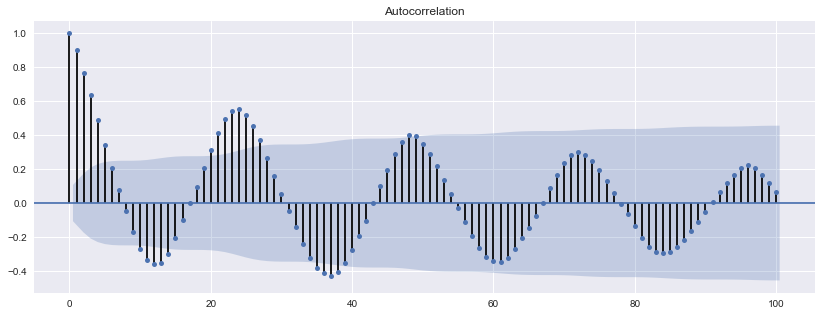

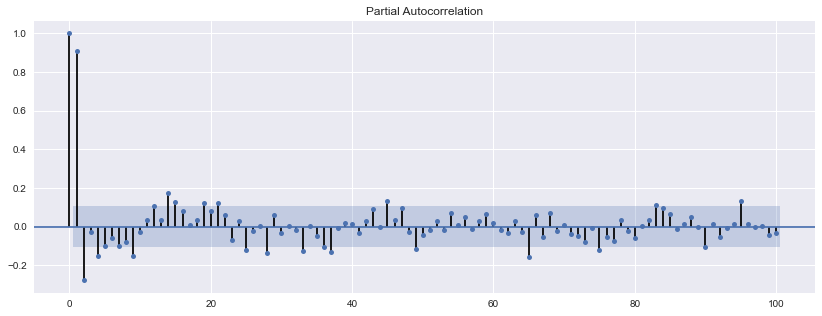

In [22]:
#get avail bikes time series for a given interval
ts = station_3172.avail_bikes_ts(time_interval=('2018-06-17','2018-06-30'))

plt.rcParams['figure.figsize'] = 14, 5
plot_acf(ts, lags=100);
plot_pacf(ts, lags=100);

### Busiest Stations

The Busiest Citibike Stations are near major transit hubs and Business areas: Grand Central, Penn Station, PATH stations, Union Square, Columbus Circle, and the World Trade Center. This implies that many users of citibike also use other forms of public transit in conjunction with citibike. For commuter rail riders like NJ Transit, Metro North, Long Island Rail Road and PATH, citibike may provide the last leg of their trip, avoiding a monthly metrocard for the subway.

In [37]:
#get top 25 stations by starttime counts
top25_starts = pd.DataFrame.from_dict({'id':list(trips_2018.start_station_id.value_counts().index)[:25],
                                       'startcount':list(trips_2018.start_station_id.value_counts())[:25]})

#get name, latitude and longitutde for top 25 stations
top25_starts['name'] = top25_starts.id.map(
    lambda x:trips_2018.loc[trips_2018.start_station_id == x].start_station_name.values[0])
top25_starts['lat'] = top25_starts.id.map(
    lambda x:trips_2018.loc[trips_2018.start_station_id == x].start_station_latitude.values[0])
top25_starts['lon'] = top25_starts.id.map(
    lambda x:trips_2018.loc[trips_2018.start_station_id == x].start_station_longitude.values[0])
top25_starts

,id,startcount,name,lat,lon
0,519.0,150257,Pershing Square North,40.751873,-73.977706
1,497.0,108883,E 17 St & Broadway,40.737050,-73.990093
2,435.0,107165,W 21 St & 6 Ave,40.741740,-73.994156
3,402.0,105605,Broadway & E 22 St,40.740343,-73.989551
4,426.0,94466,West St & Chambers St,40.717548,-74.013221
5,285.0,93370,Broadway & E 14 St,40.734546,-73.990741
6,477.0,87956,W 41 St & 8 Ave,40.756405,-73.990026
7,490.0,85293,8 Ave & W 33 St,40.751551,-73.993934
8,499.0,84963,Broadway & W 60 St,40.769155,-73.981918
9,293.0,83025,Lafayette St & E 8 St,40.730207,-73.991026


In [42]:
import plotly.express as px

px.set_mapbox_access_token(api_key)
fig = px.scatter_mapbox(top25_starts, lat="lat", lon="lon",
                        hover_name='name',hover_data=['id','startcount'],
                        zoom=12,width=800,height=800)

fig.show()